# Generate Data

In [1]:
# TODO content

## (1) Using Chimera to Create CryoEM Data

First, we created faithful Cryo-EM data for the neural networks training (including the imaging parameters that you can play with).
This is done by generating these ground truths from scratch.

The steps for generating simulation data with [chimera](https://www.cgl.ucsf.edu/chimera/):
- **Chimera software:** Download chimera from this [page](https://www.cgl.ucsf.edu/chimera/download.html).
- **Protein in PDB:** Find a protein that interests you in the [Protein Data Bank (PDB)](https://www.rcsb.org/) (let's say we take beta-galactosidase, with PDB ID [**5J0N**](https://www.rcsb.org/structure/5A1A)).
- **PDB model:** Open chimera and import that protein: File -> Fetch By ID... -> Select PDB and type the PDB ID of the protein -> Fetch. Now you will see the 3D structure of the protein.
- **Create reference map from PDB model:** Modify the density of the protein: Tools -> General Controls -> Command Line -> Type: `molmap # 5` (molmap = is command that generates a density map from the specified atom; # is atom specification, i.e. number assigned to the model by default; 5 = resolution which for us does not have sense to work with resolutions above 15, we will have proteins around 2 or 3 Angstrom).
- **Store reference map as MRC**: Save to a file: Tools -> Volume Data -> Volume Viewer -> File -> Save map as... -> Give it the `protein_PDB_ID.mrc`.

References for more information:
- [Cryo-EM: How to generate an initial reference map from PDB](http://molecularart.dk/2015/10/cryo-em-how-to-generate-an-initial-reference-map-from-pdb/)
- [Eduardo's Guide for 3D Printing Proteins](https://munfred.com/proteins.pdf).

In this notebook we will be working with the protein PDB ID **5J0N** (asymmetric protein).
![](figures/5j0n.pdb1-500.jpg)

In [1]:
PROTEIN = "5j0n"

---

## (2) Generate 2D Projections with Angles

From the 3D protein structure, we want to generate 2D projections that were taken at different angles. This is done using the `cryoem` software tools implemented in this project that rely on [Astra Toolbox](https://github.com/astra-toolbox/astra-toolbox).

In this notebook we visualize the output of this generator. We have two types of visualization:
- Euclidean angle space which represents at which angles the ray was sent through the protein. Imagine the protein in the center of the coordinate system and the potential ray positions cover the sphere around that protein with the fixed radius (i.e. only the border of the sphere is filled, the sphere itself is empty). It can also be described as camera positions around the protein.
- [SO(3) space](https://en.wikipedia.org/wiki/3D_rotation_group) with the topology explained [here](https://en.wikipedia.org/wiki/3D_rotation_group#Topology). The possible positions fill the ball with radius that is in the range from $-\pi$ to $\pi$. For every point in this ball there is a rotation, with axis through the point and the origin, and rotation angle equal to the distance of the point from the origin.

Note: The goal of this project is to recover these positions of angles on the sphere only using the projections (images) not knowing the angle at which they were taken.

Following command line will be used to run the script for generating 2D projections with angles. Note: `cd ../../..` is just locating into the root of this project. So if you run it in the root, you don't need it.

In [2]:
!cd ../../..;python generator.py --help

usage: generator.py [-h] --config-file CONFIG_FILE [--input-file INPUT_FILE]
                    [--projections-num PROJECTIONS_NUM]
                    [--angle-shift ANGLE_SHIFT]
                    [--angle-coverage ANGLE_COVERAGE]
                    [--output-file OUTPUT_FILE]

Generator of 2D projections of 3D Cryo-Em volumes Args that start with '--'
(eg. --input-file) can also be set in a config file (protein.config or
specified via --config-file). Config file syntax allows: key=value, flag=true,
stuff=[a,b,c] (for details, see syntax at https://goo.gl/R74nmi). If an arg is
specified in more than one place, then commandline values override config file
values which override defaults.

optional arguments:
  -h, --help            show this help message and exit
  --config-file CONFIG_FILE, -conf CONFIG_FILE
                        Config file path
  --input-file INPUT_FILE, -in INPUT_FILE
                        Input file of 3D volume (*.mrc format)
  --projections-num PROJECTION

In [3]:
ROOT_DIR = "../../.."

In [4]:
import os
import h5py
import numpy as np   

import sys
sys.path.append(ROOT_DIR) 
from cryoem.projections import RotationMatrix

import pathlib
pathlib.Path("data").mkdir(parents=True, exist_ok=True)
pathlib.Path("figures").mkdir(parents=True, exist_ok=True)

### (2.1) Full-Sphere Coverage - 5K Projections

Generating the 5000 projection images that were taken from angles covering the full sphere around the protein.

To generate simulation data of the protein, you can run the following command.
```
python generator.py -conf protein.config --input-file data/5j0n.mrc -num 5000 -shift 0.0 -shift 0.0 -shift 0.0 -cov 2.0 -cov 1.0 -cov 2.0
```
Note that the alternative way is just to change the config file `protein.config` with the modifications that you need. In that case it is sufficient to only run the following command:
```
python generator.py -conf protein.config
```

For every projection, we will have 3 angles, each representing the rotation around the corresponding axis. In our case we are dealing with $Z-Y-Z$ rotations:
- Z in $[0, 2\pi]$
- Y in $[0, \pi]$
- Z in $[0, 2\pi]$

In [5]:
# location of *.h5 files
data_dir = f"{ROOT_DIR}/data"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,1.0,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data_full_5k = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"angles shape: {data_full_5k['Angles'].shape} \nangles min: {np.min(data_full_5k['Angles'], axis=0)} \nangles max: {np.max(data_full_5k['Angles'], axis=0)}")

angles shape: (5000, 3) 
angles min: [0.00075142 0.00065469 0.00054268] 
angles max: [6.28246415 3.14142652 6.2814087 ]


### (2.2) Full-Sphere Coverage - 50K Projections

Generating the 50000 projection images that were taken from angles covering the full sphere around the protein.

To generate simulation data of the protein, you can run the following command.
```
python generator.py -conf protein.config --input-file data/5j0n.mrc -num 50000 -shift 0.0 -shift 0.0 -shift 0.0 -cov 2.0 -cov 1.0 -cov 2.0
```
Note that the alternative way is just to change the config file `protein.config` with the modifications that you need. In that case it is sufficient to only run the following command:
```
python generator.py -conf protein.config
```

For every projection, we will have 3 angles, each representing the rotation around the corresponding axis. In our case we are dealing with $Z-Y-Z$ rotations:
- Z in $[0, 2\pi]$
- Y in $[0, \pi]$
- Z in $[0, 2\pi]$

In [6]:
# location of *.h5 files
data_dir = f"{ROOT_DIR}/data"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber50000_AngCoverage2.0,1.0,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data_full_50k = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"angles shape: {data_full_50k['Angles'].shape} \nangles min: {np.min(data_full_50k['Angles'], axis=0)} \nangles max: {np.max(data_full_50k['Angles'], axis=0)}")

angles shape: (50000, 3) 
angles min: [3.32076158e-04 1.86155811e-04 3.90353060e-05] 
angles max: [6.28308765 3.14153797 6.28300532]


### (2.3) Half-Sphere Coverage - 5K Projections

Generating the 5000 projection images that were taken only from angles covering almost the half sphere around the protein.

To generate simulation data of the protein, you can run the following command.
```
python generator.py -conf protein.config --input-file data/5j0n.mrc -num 5000 -shift 0.0 -shift 0.0 -shift 0.0 -cov 2.0 -cov 0.4 -cov 2.0
```
Note that the alternative way is just to change the config file `protein.config` with the modifications that you need. In that case it is sufficient to only run the following command:
```
python generator.py -conf protein.config
```

For every projection, we will have 3 angles, each representing the rotation around the corresponding axis. In our case we are dealing with $Z-Y-Z$ rotations:
- Z in $[0, 2\pi]$
- Y in $[0, 0.4\cdot\pi]$
- Z in $[0, 2\pi]$

In [7]:
# location of *.h5 files
data_dir = f"{ROOT_DIR}/data"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data_half_5k = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"angles shape: {data_half_5k['Angles'].shape} \nangles min: {np.min(data_half_5k['Angles'], axis=0)} \nangles max: {np.max(data_half_5k['Angles'], axis=0)}")

angles shape: (5000, 3) 
angles min: [0.00085197 0.00011532 0.00189638] 
angles max: [6.28154818 1.25565129 6.28261737]


### (2.4) Half-Sphere Coverage - 50K Projections

Generating the 5000 projection images that were taken only from angles covering almost the half sphere around the protein.

To generate simulation data of the protein, you can run the following command.
```
python generator.py -conf protein.config --input-file data/5j0n.mrc -num 50000 -shift 0.0 -shift 0.0 -shift 0.0 -cov 2.0 -cov 0.4 -cov 2.0
```
Note that the alternative way is just to change the config file `protein.config` with the modifications that you need. In that case it is sufficient to only run the following command:
```
python generator.py -conf protein.config
```

For every projection, we will have 3 angles, each representing the rotation around the corresponding axis. In our case we are dealing with $Z-Y-Z$ rotations:
- Z in $[0, 2\pi]$
- Y in $[0, 0.4\cdot\pi]$
- Z in $[0, 2\pi]$

In [8]:
# location of *.h5 files
data_dir = f"{ROOT_DIR}/data"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber50000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data_half_50k = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"angles shape: {data_half_50k['Angles'].shape} \nangles min: {np.min(data_half_50k['Angles'], axis=0)} \nangles max: {np.max(data_half_50k['Angles'], axis=0)}")

angles shape: (50000, 3) 
angles min: [2.22489134e-04 3.03306006e-05 9.37026626e-07] 
angles max: [6.28311547 1.25660771 6.2830992 ]


---

## (3) Visualizations

In [9]:
from IPython.display import Image
import ipyvolume as ipv

from cryoem.plots import plot_euclidean_space, save_space_plot, plot_SO3_space

### (3.1) Euclidean Angle Space

As described above: Euclidean angle space which represents at which angles the ray was sent through the protein. Imagine the protein in the center of the coordinate system and the potential ray positions cover the sphere around that protein with the fixed radius (i.e. only the border of the sphere is filled, the sphere itself is empty). It can also be described as camera positions around the protein.

#### (3.1.1) Full-Sphere Coverage - 5K Projections

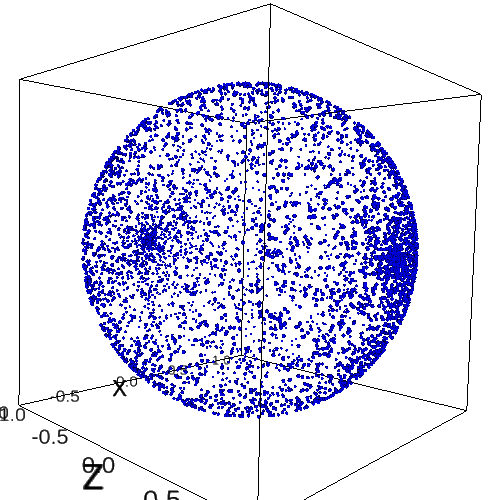

In [10]:
plot_euclidean_space(data_full_5k['Angles'])

In [11]:
filename = f"figures/{PROTEIN}_preparation_raydir_5K_full"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

#### (3.1.2) Full-Sphere Coverage - 50K Projections

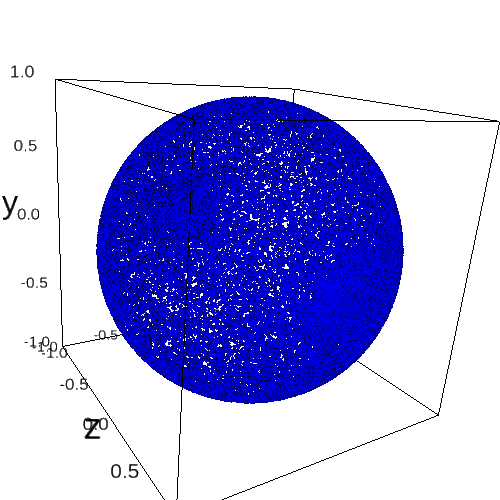

In [12]:
plot_euclidean_space(data_full_50k['Angles'])

In [13]:
filename = f"figures/{PROTEIN}_preparation_raydir_50K_full"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

#### (3.1.3) Half-Sphere Coverage - 5K Projections

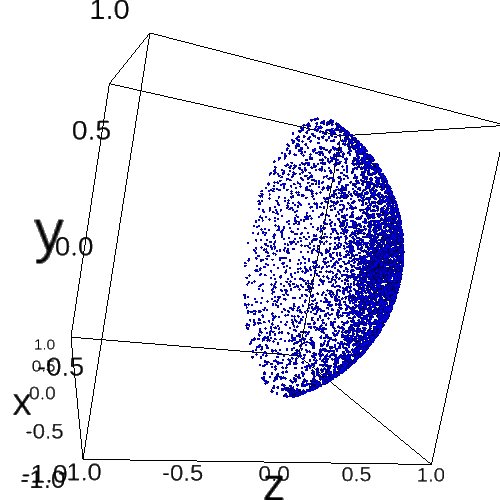

In [14]:
plot_euclidean_space(data_half_5k['Angles'])

In [15]:
filename = f"figures/{PROTEIN}_preparation_raydir_5K_half"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

#### (3.1.4) Half-Sphere Coverage - 50K Projections

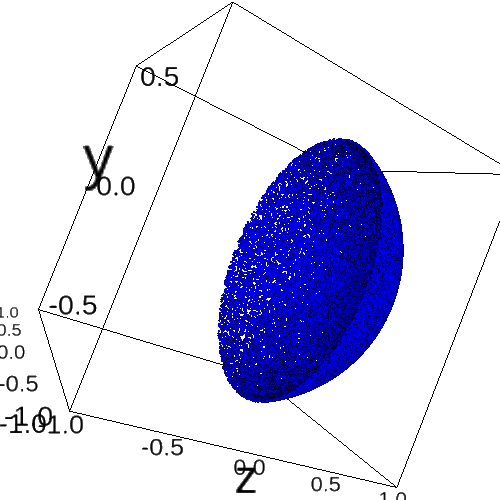

In [16]:
plot_euclidean_space(data_half_50k['Angles'])

In [17]:
filename = f"figures/{PROTEIN}_preparation_raydir_50K_half"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

### (3.2) SO(3) space

As mentioned above: [SO(3) space](https://en.wikipedia.org/wiki/3D_rotation_group) with the topology explained [here](https://en.wikipedia.org/wiki/3D_rotation_group#Topology). The possible positions fill the ball with radius that is in the range from $-\pi$ to $\pi$. For every point in this ball there is a rotation, with axis through the point and the origin, and rotation angle equal to the distance of the point from the origin.

#### (3.2.1) Full-Sphere Coverage - 5K Projections

##### Not Normalized

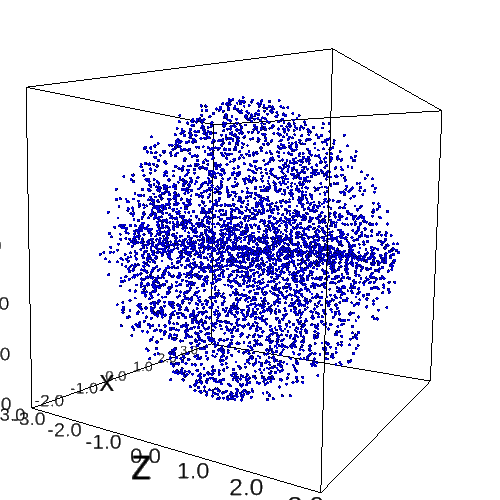

In [18]:
plot_SO3_space(data_full_5k['Angles'], normalized=False)

In [19]:
filename = f"figures/{PROTEIN}_preparation_axisangle_5K_full"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

##### Normalized

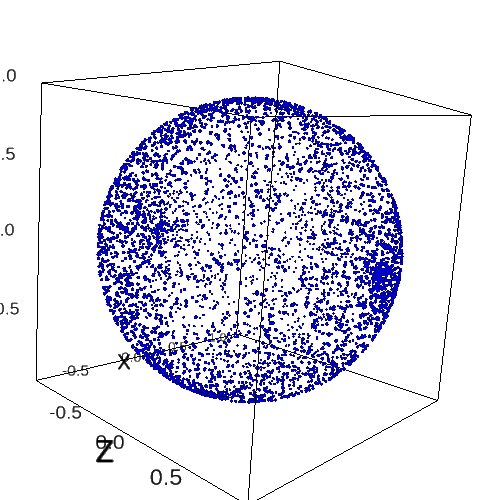

In [20]:
plot_SO3_space(data_full_5k['Angles'], normalized=True)

In [21]:
filename = f"figures/{PROTEIN}_preparation_axisangleNorm_5K_full"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

#### (3.2.2) Full-Sphere Coverage - 50K Projections

##### Not Normalized

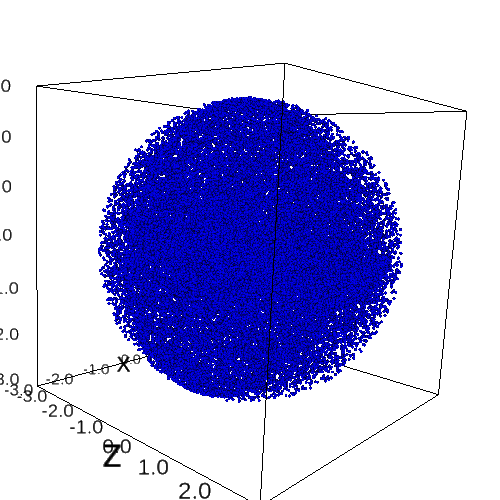

In [22]:
plot_SO3_space(data_full_50k['Angles'], normalized=False)

In [23]:
filename = f"figures/{PROTEIN}_preparation_axisangle_50K_full"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

##### Normalized

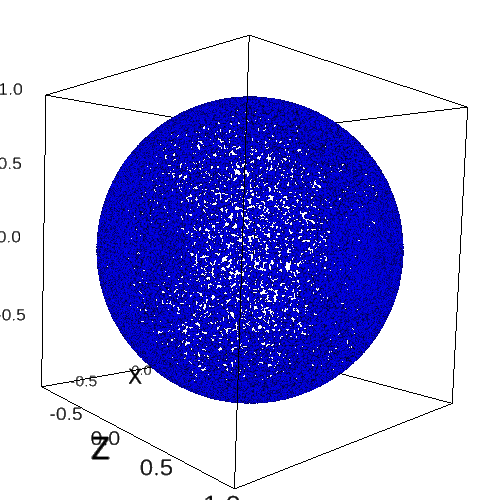

In [24]:
plot_SO3_space(data_full_50k['Angles'], normalized=True)

In [25]:
filename = f"figures/{PROTEIN}_preparation_axisangleNorm_50K_full"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

#### (3.2.3) Half-Sphere Coverage - 5K Projections

##### Not Normalized

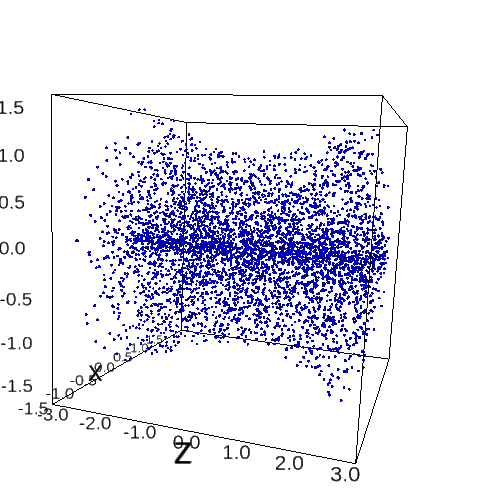

In [26]:
plot_SO3_space(data_half_5k['Angles'], normalized=False)

In [27]:
filename = f"figures/{PROTEIN}_preparation_axisangle_5K_half"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

##### Normalized

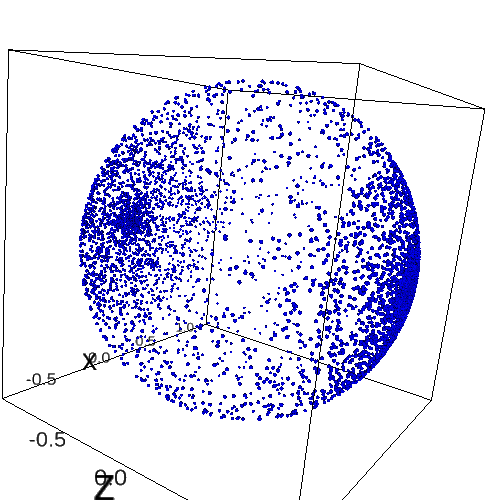

In [28]:
plot_SO3_space(data_half_5k['Angles'], normalized=True)

In [29]:
filename = f"figures/{PROTEIN}_preparation_axisangleNorm_5K_half"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

#### (3.2.4) Half-Sphere Coverage - 50K Projections

##### Not Normalized

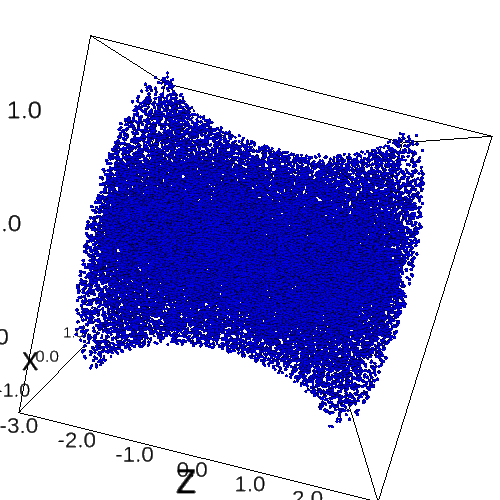

In [30]:
plot_SO3_space(data_half_50k['Angles'], normalized=False)

In [31]:
filename = f"figures/{PROTEIN}_preparation_axisangle_50K_half"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

##### Normalized

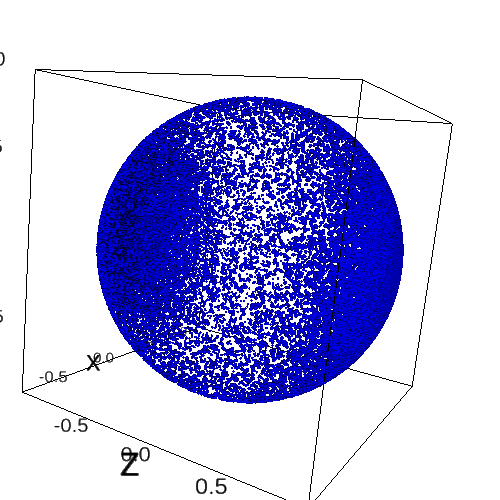

In [32]:
plot_SO3_space(data_half_50k['Angles'], normalized=True)

In [33]:
filename = f"figures/{PROTEIN}_preparation_axisangleNorm_50K_half"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

---

## (4) Projections

Through the following model, we consider that a cryo-EM measurement (i.e. 2D projection) $\mathbf{y}_i \in \mathbb{R}^{M}$ is acquired through
\begin{equation}
\label{eq:linear-forward-model}
\mathbf{y}_i={\mathbf {C}_{\boldsymbol\varphi}}\mathbf S_{\mathbf{t}}\mathbf P_{\theta_i}\mathbf x+\mathbf n,
\end{equation}
where $\mathbf x \in \mathbb{R}^{V}$ is the unknown 3D density map\cite{dimaio_creating_2007} (Coulomb potential). The operator $\mathbf P_{\theta_i}: \mathbb R^V \to \mathbb R^M$ is the projection along the 3D pose $\theta_i$ (i.e., the x-ray transform). The operator $\mathbf S_\mathbf{t}: \mathbb R^M \to \mathbb R^M$ is a shift of the projection by $\mathbf{t}=(t_1, t_2)$. The convolution operator $\mathbf {C}_{\boldsymbol\varphi}: \mathbb R^M \to \mathbb R^M$ models the microscope contrast transfer function (CTF) with parameters $\boldsymbol\varphi=(d_1, d_2, \alpha_{\rm ast})$, that are, respectively, the defocus-major, the defocus-minor and the angle of astigmatism. Finally, $\mathbf n \in \mathbb{R}^{M}$ represents an additive noise. Our goal is then to recover the angles $\theta_i$ from every projection $\mathbf y_i$. 

The stages of the project development are the following:

1. Testing the **feasibility** of the algorithms as well as the whole pipeline. In this stage we are only using one protein 3D volume $\mathbf x$. The set of projections is created using the projection $\mathbf P_{\theta_i}$ along the 3D pose $\theta_i$. We do not consider the effects of noise, shift, etc. The 2D projection set $\{\mathbf y_i\}$ is then split into disjoint training $\{\mathbf y_{i}^{train}\}$ and test $\{\mathbf y_{i}^{test}\}$ sets.  
  $\mathbf x \rightarrow \{\mathbf y_i\} = \{\mathbf P_{\theta_i } \mathbf x\} \implies \{\mathbf y_{i}^{train}\} \cup \{\mathbf y_{i}^{test}\} = \{\mathbf y_i\}  \land \{\mathbf y_{i}^{train}\} \cap \{\mathbf y_{i}^{test}\} = \emptyset$
  
2. Testing the **robustness to noise** $\mathbf n$. This stage presents the extension of the previous stage. Same as before, we are only using one protein 3D volume $\mathbf x$ and the set of projections is created using the projection $\mathbf P_{\theta_i}$ along the 3D pose $\theta_i$. Here we include the noise $\mathbf n$ to crate the set of 2D projections $\{\mathbf y_i\}$. The 2D projection set $\{\mathbf y_i\}$ is then split into disjoint training $\{\mathbf y_{i}^{train}\}$ and test $\{\mathbf y_{i}^{test}\}$ sets.  
  $\mathbf x \rightarrow \{\mathbf y_i\} = \{\mathbf P_{\theta_i } \mathbf x + \mathbf n\} \implies \{\mathbf y_{i}^{train}\} \cup \{\mathbf y_{i}^{test}\} = \{\mathbf y_i\}  \land \{\mathbf y_{i}^{train}\} \cap \{\mathbf y_{i}^{test}\} = \emptyset$
  
3. Testing the **robustness to unseen protein volumes**. In this stage, we have $N$ protein 3D volumes that are used to create the training set of 2D projections $\{\mathbf y_{N, i}^{train}\}$. Another, unseen protein 3D volume $\mathbf x^{test}$ is used to create the test set of 2D projections $\{\mathbf y_i^{test}\}$. The set of projections is created using the projection $\mathbf P_{\theta_i}$ along the 3D pose $\theta_i$. We do not consider the effects of noise, shift, etc.  
  $\{\mathbf x_1^{train}, ..., \mathbf x_N^{train}\}   \rightarrow \{\mathbf y_{N, i}^{train}\} = \{\mathbf P_{\theta_i } \mathbf x_N^{train}\}$  
  $\mathbf x^{test} \rightarrow \{\mathbf y_i^{test}\} = \{\mathbf P_{\theta_i } \mathbf x^{test}\}$
  
4. Testing the **faithfulness** of $\mathbf H_{\phi}$. We are only using one protein 3D volume $\mathbf x$ and the set of projections is created using the projection $\mathbf P_{\theta_i}$ along the 3D pose $\theta_i$ as well as all the other operators (noise $\mathbf n$, CTF $\mathbf C_\varphi$, shift $\mathbf S_{\mathbf t}$) specified in the equation. The 2D projection set $\{\mathbf y_i\}$ is then split into disjoint training $\{\mathbf y_{i}^{train}\}$ and test $\{\mathbf y_{i}^{test}\}$ sets.  
  $\mathbf x \rightarrow \{\mathbf y_i\} = \{{\mathbf {C}_{\boldsymbol\varphi}}\mathbf S_{\mathbf{t}}\mathbf P_{\theta_i}\mathbf x+\mathbf n\} = \{\mathbf H_\phi \mathbf x+\mathbf n\} \implies \{\mathbf y_{i}^{train}\} \cup \{\mathbf y_{i}^{test}\} = \{\mathbf y_i\}  \land \{\mathbf y_{i}^{train}\} \cap \{\mathbf y_{i}^{test}\} = \emptyset$
  
5. Final **goal**. We have $N$ protein 3D volumes that are used to create the training set of 2D projections $\{\mathbf y_{N, i}^{train}\}$. Another, unseen protein 3D volume $\mathbf x^{test}$ is used to create the test set of 2D projections $\{\mathbf y_i^{test}\}$. The set of projections is created using the projection $\mathbf P_{\theta_i}$ along the 3D pose $\theta_i$ as well as all the other operators (noise $\mathbf n$, CTF $\mathbf C_\varphi$, shift $\mathbf S_{\mathbf t}$) specified in the main equation.  
  $\{\mathbf x_1^{train}, ..., \mathbf x_N^{train}\}  \rightarrow \{\mathbf y_{N, i}^{train}\} = \{{\mathbf {C}_{\boldsymbol\varphi}}\mathbf S_{\mathbf{t}}\mathbf P_{\theta_i}\mathbf x_N^{train}+\mathbf n\}$  
  $\mathbf x^{test} \rightarrow \{\mathbf y_i^{test}\} =\{{\mathbf {C}_{\boldsymbol\varphi}}\mathbf S_{\mathbf{t}}\mathbf P_{\theta_i}\mathbf x^{test}+\mathbf n\}$


In [34]:
import sys
sys.path.append(ROOT_DIR) 
from cryoem.plots import plot_projection, plot_projections
from cryoem.noise import gaussian_noise

In [35]:
data = data_full_5k

### (4.1) Plotting Projections without Noise

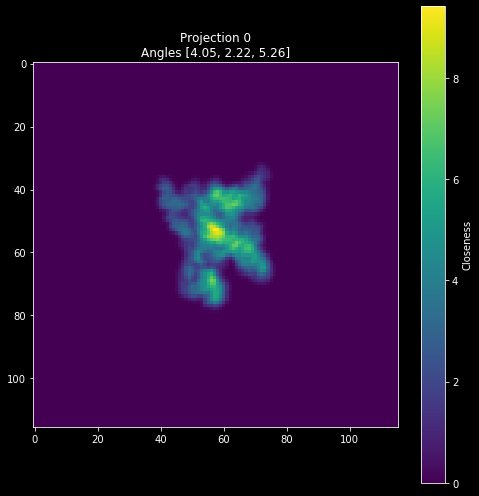

In [36]:
datapoint = 0
image = data["Projections"][datapoint]
angles = [ float(f"{x:.2f}") for x in data["Angles"][datapoint] ]
title = f'Projection {datapoint}\nAngles {angles}'
    
plot_projection(image, title)

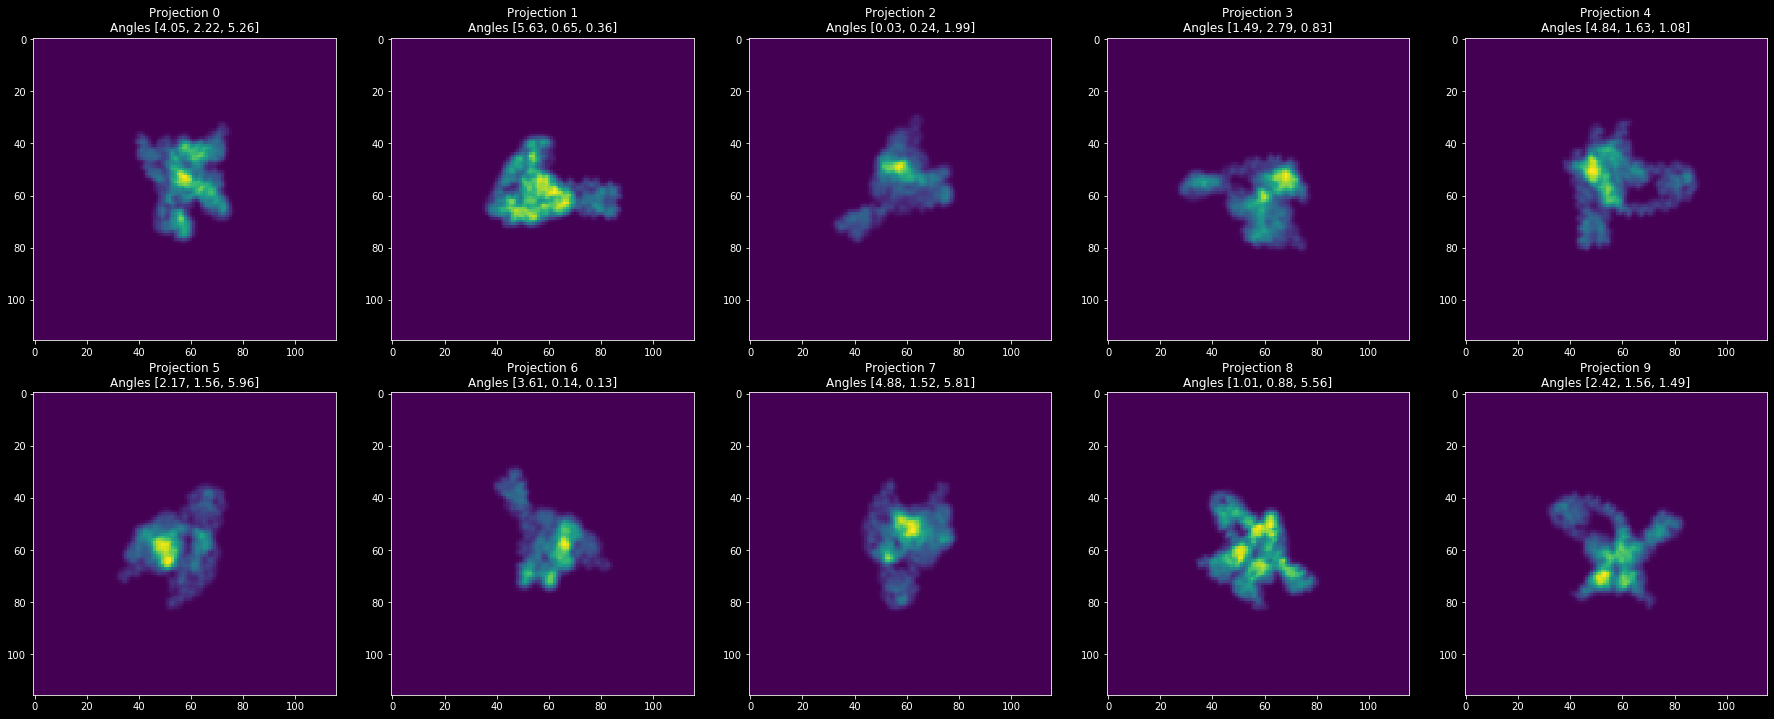

In [37]:
nrows, ncols = 2, 5
start_row, start_col = 0, 0

images = []
titles = []

cr = [(i, j) for i in range(nrows) for j in range(ncols)]

for i, j in cr:
    datapoint = (start_row + i)*(start_col + ncols) + j    

    image = data["Projections"][datapoint]
    image = image + gaussian_noise(shape=image.shape, mean=0, var=0)

    angles = [ float(f"{x:.2f}") for x in data["Angles"][datapoint] ]
    title = f'Projection {datapoint}\nAngles {angles}'
    
    images.append(image)
    titles.append(title)
        
plot_projections(images, titles, nrows=nrows, ncols=ncols)

### (4.2) Plotting Projections with Gaussian Noise

Gaussian noise settings:

In [38]:
mean = 0
var = 50

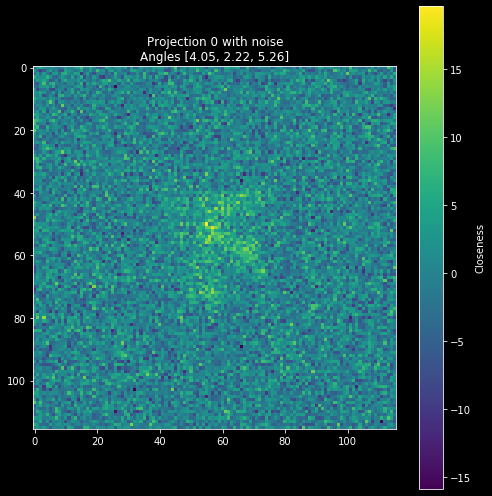

In [39]:
datapoint = 0
image = data["Projections"][datapoint]
image = image + gaussian_noise(image.shape, mean=0, var=15)
angles = [ float(f"{x:.2f}") for x in data["Angles"][datapoint] ]
title = f'Projection {datapoint} with noise\nAngles {angles}'
    
plot_projection(image, title, mean=0, var=100)

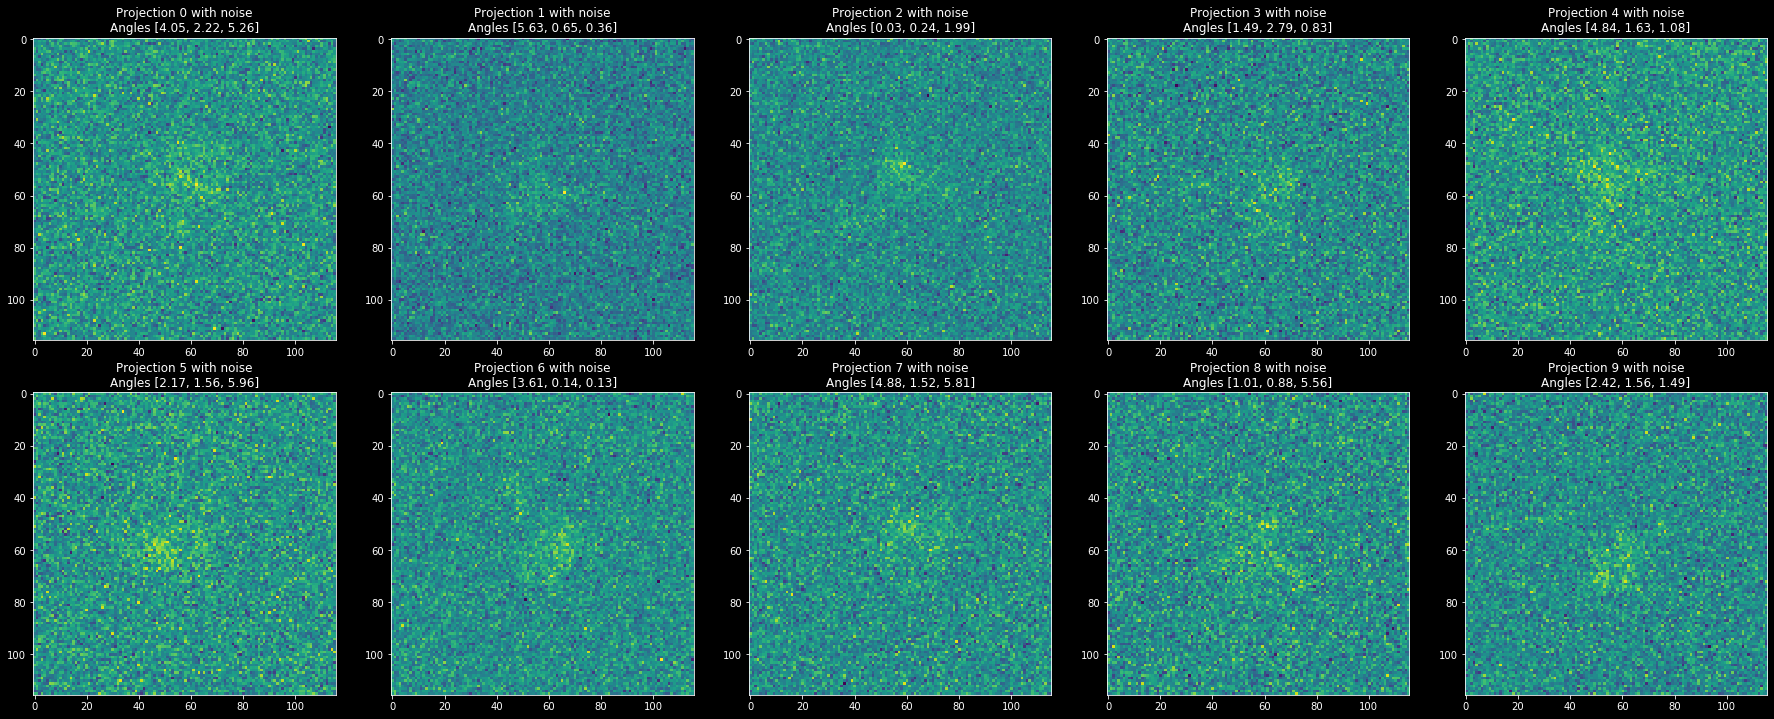

In [40]:
nrows, ncols = 2, 5
start_row, start_col = 0, 0

images = []
titles = []

cr = [(i, j) for i in range(nrows) for j in range(ncols)]

for i, j in cr:
    datapoint = (start_row + i)*(start_col + ncols) + j    

    image = data["Projections"][datapoint]
    image = image + gaussian_noise(shape=image.shape, mean=mean, var=var)

    angles = [ float(f"{x:.2f}") for x in data["Angles"][datapoint] ]
    title = f'Projection {datapoint} with noise\nAngles {angles}'
    
    images.append(image)
    titles.append(title)
        
plot_projections(images, titles, nrows=nrows, ncols=ncols)

---

## (5) k-NN Closest Projections

In [41]:
from sklearn.neighbors import NearestNeighbors
import time
from cryoem.plots import plot_one_closest_vs_all_in_SO3_space, plot_only_closest_in_SO3_space, plot_one_closest_vs_all_in_euclidean_space, plot_only_closest_in_euclidean_space

In [42]:
data = data_full_5k
file_name_prefix = f"{PROTEIN}_full_5k" 

In [43]:
X = np.reshape(data["Projections"], (data["Projections"].shape[0], -1))
X.shape

(5000, 13456)

In [44]:
start_time = time.time()

if not os.path.exists(f'data/{file_name_prefix}_distances.npy'):
    nbrs = NearestNeighbors(n_neighbors=6, algorithm='ball_tree').fit(X)
    distances, indices = nbrs.kneighbors(X)
    connections = nbrs.kneighbors_graph(X).toarray()
    
    np.save(f'data/{file_name_prefix}_indices', indices)         # Indices of the nearest points in the population matrix
    np.save(f'data/{file_name_prefix}_distances', distances)     # Array representing the lengths to points
    np.save(f'data/{file_name_prefix}_connections', connections) # Sparse graph showing the connections between neighboring points
    
else:
    indices     = np.load(f'data/{file_name_prefix}_indices.npy')     # shape: NUM_IMGS, NUM_NEIGHBOURS
    distances   = np.load(f'data/{file_name_prefix}_distances.npy')   # shape: NUM_IMGS, NUM_NEIGHBOURS
    connections = np.load(f'data/{file_name_prefix}_connections.npy') # shape: NUM_IMGS, NUM_IMGS
    
print(f"--- {time.time() - start_time} seconds ---")

--- 0.031161785125732422 seconds ---


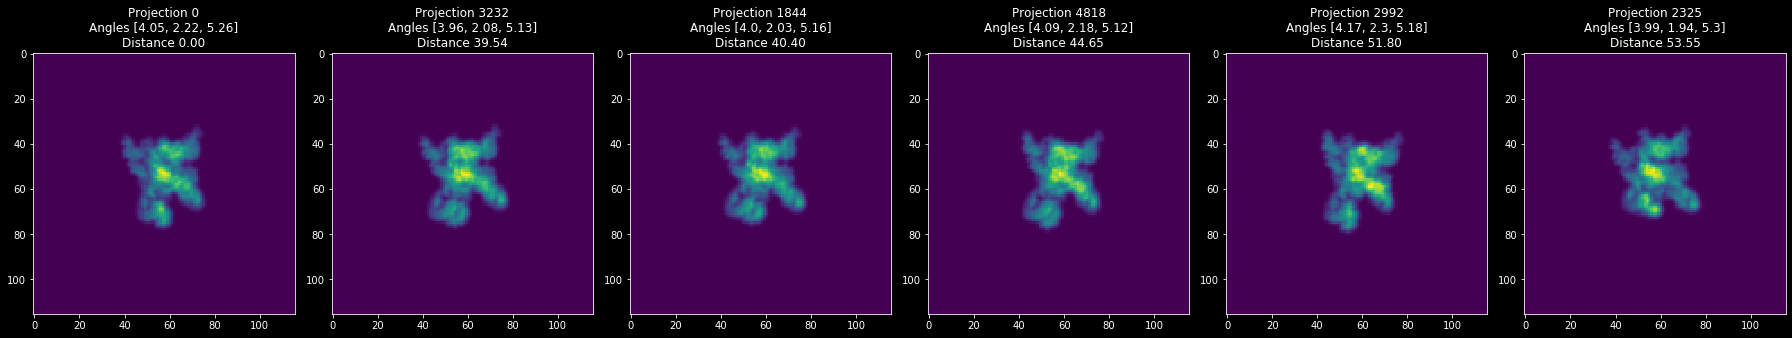

In [45]:
indices1 = indices[0]
distances1 = distances[0]

nrows, ncols = 1, 6
start_row, start_col = 0, 0

images = []
titles = []

cr = [(i, j) for i in range(nrows) for j in range(ncols)]

for datapoint, distance in zip(indices1, distances1):
    image = data["Projections"][datapoint]
    image = image #+ gaussian_noise(shape=image.shape, mean=0, var=0)

    angles = [ float(f"{x:.2f}") for x in data["Angles"][datapoint] ]
    title = f'Projection {datapoint}\nAngles {angles}\nDistance {distance:.2f}'
    
    images.append(image)
    titles.append(title)
        
plot_projections(images, titles, nrows=nrows, ncols=ncols)

These are top 5 similar projection images to the first one in the row.

###### Euclidean Space

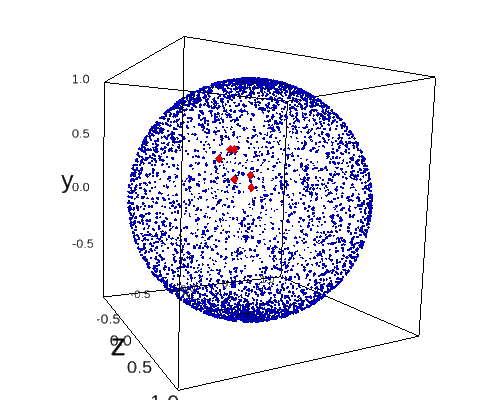

In [46]:
plot_one_closest_vs_all_in_euclidean_space(data["Angles"], indices[1])

In [47]:
filename = f"figures/{PROTEIN}_preparation_knn"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

###### SO(3) space

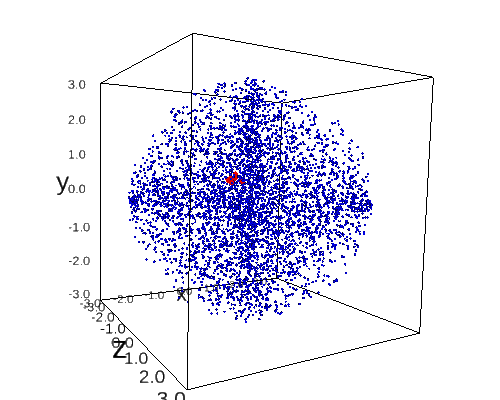

In [49]:
plot_one_closest_vs_all_in_SO3_space(data['Angles'], closest=indices[1])

In [50]:
filename = f"figures/{PROTEIN}_preparation_knn_so3"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

Indeed, form the visualizations above we can see that if two projections are close in projection space (we found closest with knn) they will be close in angle space as well.

###### Euclidean Angle Space

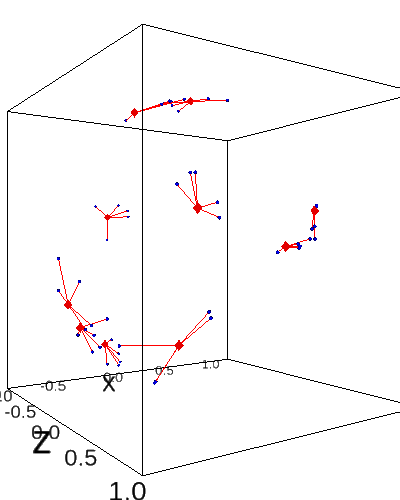

In [51]:
plot_only_closest_in_euclidean_space(data["Angles"], indices[:10])

In [52]:
filename = f"figures/{PROTEIN}_preparation_knn_10"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

###### SO(3) Space

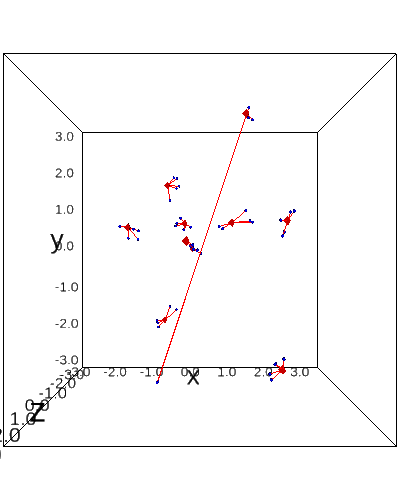

In [53]:
plot_only_closest_in_SO3_space(data["Angles"], indices[:10])

In [54]:
filename = f"figures/{PROTEIN}_preparation_knn_so3_10"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

This pair that is really far away from its closest projection is explained by the fact that in SO(3) space $-\pi$ and $\pi$ are considered the same set of rotations.